# Identify Duplicate Bug Reports Using Siamese Cross-Encoder Network

## Load Data

In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from typing import List, Dict, Tuple, Set
import itertools

In [2]:
def load_dataset(limit=0, verbose=False):
  client = MongoClient()
  db = client['eclipse']
  bug_collection = db['clear']
  pairs_collection = db['pairs']

  pairs: Tuple[Dict] = tuple(pairs_collection.find(limit=limit))
  if verbose:
    print('total pairs', len(pairs))
  bug_groups = [[pair['bug1'], pair['bug2']] for pair in pairs]
  candidate_bug_ids = [
    str(bug_id)
    for bug_group in bug_groups for bug_id in bug_group
  ]
  if verbose:
    print('total candidate_bug_ids', len(candidate_bug_ids))

  # Storing bug reports as dictionary so that they can be
  # retrieved by bug_id
  bug_reports: Dict[str, Dict] = {}
  for bug_report in bug_collection.find({'bug_id': {'$in': candidate_bug_ids}}):
    bug_reports[bug_report['bug_id']] = bug_report
  if verbose:
    print('total bug_reports', len(bug_reports))

  return bug_reports, pairs

In [3]:
def create_dataframe(bug_reports: Dict[str, Dict], pairs: Tuple[Dict]):
  data = [
    [
      bug_reports[str(pair['bug1'])]['short_desc'],
      bug_reports[str(pair['bug2'])]['short_desc'],
      bug_reports[str(pair['bug1'])]['description'],
      bug_reports[str(pair['bug2'])]['description'],
      False if pair['dec'] == -1 else True]
    for pair in pairs
  ]

  columns = ['title1', 'title2', 'description1', 'description2', 'is_similar']

  return pd.DataFrame(data=data, columns=columns)

In [4]:
def unidecode_str_cols(df: pd.DataFrame):
  from unidecode import unidecode

  def decode_col(col: pd.Series):
    if pd.api.types.is_string_dtype(col.dtype):
      # unidecode throws following weird error on empty string
      # 'list' object has no attribute 'encode'
      return col.apply(lambda sent: unidecode(sent) if sent else sent)
    return col

  return df.apply(decode_col)

In [5]:
dup_df = unidecode_str_cols(create_dataframe(*load_dataset()))
print('Data shape:', dup_df.shape)
dup_df.sample(n=10, random_state=13)

Data shape: (271098, 5)


,title1,title2,description1,description2,is_similar
233357,Links on preference pages are opened in browser,FileDialog: File paths incorrect,Open the Preference Dialog\nGo to the Java/Edi...,eclipse r2.0 (20020627) \nredhat 7.3 (gtk) \n...,False
265890,Getting NumberFormatException while running ANT,ANT build fails to display warning message,I am getting this problem only in 3.1 versions...,I'm running external ANT v 1.6.1 under eclipse...,True
117082,NPE throws out when click on data item in layo...,[ui] Available software dialog should preserve...,Created attachment 78045\nreport design\n\nDes...,1) When applying a filter in the available sof...,False
121372,[Bugs] Renaming a query in History fails silently,[search] Ability to scope the locations searched,The Rename menu command is available on a Quer...,It would be useful to have some way of scoping...,False
115238,[Xtext] NPE during link,Please add cdamus to group emfadmin,Created attachment 103039\nProposed Patch\n\nV...,In order to publish builds of components that ...,False
44796,dynamic pagebreak issue,Modules support in JEEDeployableFactory,Created attachment 101804\nZip containing a re...,Build ID: 3.4 M6\n\nSteps To Reproduce:\norg.e...,False
59542,Support Bugzilla 3.0 custom resolutions,Warning logged about undefined tm.terminal com...,It would be nice if custom resolutions were su...,"I don't recall seeing this in the log before, ...",False
156949,unclear NLS messages in spelling,Render breakpoints in context of debug target,JavaUIMessages.properties:\n\nSpelling.error.c...,In conjunction with bug# 6213\n\nWhen only one...,False
159686,ClassNotPreparedException attempting to Displa...,ClassNotLoadedException during conditional bre...,"1. Stepping through some code\n\n2. oddly, 'th...","Build: M5 ++\n\nPut a breakpoint on line 4, ""S...",True
126786,Do not default to VariableOneToOneMapping for ...,Unexpected errors while reconciling,EclipseLink default interfaces to VariableOneT...,"Build 20020515\n\nIn self-hosted workspace, op...",False


In [6]:
print('Data Types:')
dup_df.dtypes

Data Types:


title1          object
title2          object
description1    object
description2    object
is_similar        bool
dtype: object

In [7]:
FEATURES = ['title1', 'title2', 'description1', 'description2']
print('Description of length of the feature columns')
dup_df[FEATURES].apply(lambda col: col.str.len().describe())

Description of length of the feature columns


,title1,title2,description1,description2
count,271098.000000,271098.000000,271098.000000,271098.000000
mean,55.053542,55.119754,1460.756055,1453.384496
std,21.668583,21.671878,4302.386984,4174.773253
min,1.000000,1.000000,0.000000,0.000000
25%,40.000000,40.000000,238.000000,239.000000
50%,53.000000,53.000000,449.000000,450.000000
75%,68.000000,68.000000,940.000000,943.000000
max,255.000000,255.000000,373075.000000,373075.000000


In [8]:
print('Outliers by length:')


def count_tail_outliers(col: pd.Series):
  lengths: pd.Series = col.str.len()
  iqr = lengths.quantile(0.75) - lengths.quantile(0.25)
  outlier_range = lengths.quantile(0.75) + 1.5 * iqr
  outlier_count = sum(lengths > outlier_range)
  return pd.Series({
    'iqr': iqr,
    'count': outlier_count,
    'frac': outlier_range / len(lengths),
  })


dup_df[FEATURES].apply(count_tail_outliers)

Outliers by length:


,title1,title2,description1,description2
iqr,28.000000,28.000000,702.000000,704.000000
count,4107.000000,4141.000000,37557.000000,37824.000000
frac,0.000406,0.000406,0.007352,0.007374


### Filter out entries of insuficient length

In [9]:
dup_df = dup_df[
  (dup_df.title1.str.len() >= 10)
  & (dup_df.title2.str.len() >= 10)
  & (dup_df.description1.str.len() >= 50)
  & (dup_df.description2.str.len() >= 50)
  ]

In [10]:
print('Shape after drop:', dup_df.shape)

Shape after drop: (256649, 5)


In [11]:
dup_df.groupby(by='is_similar').apply(
  lambda group: pd.Series({
    'count': group.size,
    'frac': len(group) / len(dup_df),
  }),
)

,count,frac
is_similar,,
False,748150.0,0.583014
True,535095.0,0.416986


## Train, Validation, Test Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_val_df, test_df = train_test_split(
  dup_df,
  test_size=20000,
  stratify=dup_df.is_similar,
  random_state=13,
)

In [14]:
train_df, val_df = train_test_split(
  train_val_df,
  test_size=20000,
  stratify=train_val_df.is_similar,
  random_state=13,
)

In [15]:
print(f'Train Val Test Size: {len(train_df):,} {len(val_df):,} {len(test_df):,}')

Train Val Test Size: 216,649 20,000 20,000


## Download & Prepare Embedding

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow.keras.utils as kutils
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [17]:
def ensure_glove_embedding(verbose=False):
  import pathlib
  embedding_data_path = kutils.get_file(
    'glove.42B.300d.zip',
    'https://nlp.stanford.edu/data/glove.42B.300d.zip',
    untar=True,
    extract=True,
  )

  # If this operation fails, print the parent-dir
  # go there, and extract the file
  file_path = pathlib.Path(embedding_data_path).parent / 'glove.42B.300d.txt'

  if verbose:
    with open(file_path, encoding='utf-8') as glove_embedding_file:
      for i in range(5):
        line = glove_embedding_file.readline()
        word, *embedding = line.split()
        print(
          'Word:', word,
          '| Embedding length:', len(embedding),
          '| Average embedding:', sum(map(float, embedding)) / len(embedding),
        )

  return file_path


glove_file_path = ensure_glove_embedding(verbose=True)

Word: , | Embedding length: 300 | Average embedding: -0.02834135199999997
Word: the | Embedding length: 300 | Average embedding: -0.012646989333333348
Word: . | Embedding length: 300 | Average embedding: -0.05447891
Word: and | Embedding length: 300 | Average embedding: -0.054808682333333324
Word: to | Embedding length: 300 | Average embedding: -0.0682633267666667


### Create Embedding Index

In [18]:
def create_embedding_index(embedding_file_path: str, verbose=False):
  if verbose:
    from tqdm.notebook import tqdm

    # there are 1.9M words, and we will update progress
    # on every 1000 word read
    progress_bar = tqdm(total=1917494)

  embedding_index: Dict[str, np.ndarray] = {}
  with open(embedding_file_path, encoding='utf-8') as embedding_file:
    i = 0
    for line in embedding_file:
      i += 1
      word, coefficients = line.split(maxsplit=1)
      if i > 1917494:
        print('word:', word)
        break
      coefficients = np.fromstring(coefficients, 'float', sep=' ')
      embedding_index[word] = coefficients

      if verbose:
        if i % 1000 == 0:
          progress_bar.update(1000)

  if verbose:
    progress_bar.close()

  if verbose:
    print(f'Found {len(embedding_index)} words in the embedding.')
    print(f'Embedding dimension: {len(next(iter(embedding_index.values())))}')

  return embedding_index


embedding_index = create_embedding_index(glove_file_path, True)

  0%|          | 0/1917494 [00:00<?, ?it/s]

Found 1917494 words in the embedding.
Embedding dimension: 300


### Create Vocabulary Index

In [19]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 200
EMBEDDING_DIM = 300

In [20]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS - 2,
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [21]:
title_vectorizer, title_word_index = build_vocab(
  [*dup_df.title1, *dup_df.title2],
  MAX_TITLE_LENGTH,
)

print(
  'Most frequent title words:',
  list(itertools.islice(title_word_index.keys(), 5)),
)

Most frequent title words: ['', '[UNK]', 'in', 'to', 'not']


In [22]:
descr_vectorizer, descr_word_index = build_vocab(
  [*dup_df.description1, *dup_df.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'at', 'the', 'to']


### Create Embedding Matrix

In [23]:
def create_embedding_matrix(
  embedding_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix


In [24]:
print('Creating title embedding matrix:')
title_embedding_matrix = create_embedding_matrix(
  embedding_index, title_word_index, True,
)

print('\nCreating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embedding_index, descr_word_index, True,
)

Creating title embedding matrix:
Embedding shape: (20000, 300)
Found 12338 words, missed 7660.

Creating description embedding matrix:
Embedding shape: (20000, 300)
Found 8533 words, missed 11465.


## Prepare Training Data

In [25]:
def generate_batches(
  split_df: pd.DataFrame,
  batch_size=1024,
):
  steps_per_epoch = len(split_df) // batch_size
  while True:
    for i in range(steps_per_epoch):
      offset = i * batch_size
      till = offset + batch_size
      feature_batches = []
      for feature in FEATURES:
        vectorizer = title_vectorizer if feature.startswith('title') else descr_vectorizer
        feature_batch = vectorizer(
          split_df[feature][offset: till].to_numpy().reshape((-1, 1))
        ).numpy()
        feature_batches.append(feature_batch)


      target_batch = split_df.is_similar[offset: till].to_numpy()
      yield (
        feature_batches,
        target_batch,
      )

## Create Models

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from keras.initializers.initializers_v2 import Constant

In [27]:
TitleEmbeddingLayer = layers.Embedding(
  input_dim=MAX_TOKENS,
  output_dim=EMBEDDING_DIM,
  embeddings_initializer=Constant(title_embedding_matrix),
  trainable=False,
  name='TitleEmbeddingLayer',
)

TitleLSTMLayer = layers.Bidirectional(layers.LSTM(
  units=50,
  dropout=0.2,
  recurrent_dropout=0.2,
), name='TitleBidirectionalLSTMLayer')

DescrEmbeddingLayer = layers.Embedding(
  input_dim=MAX_TOKENS,
  output_dim=EMBEDDING_DIM,
  embeddings_initializer=Constant(descr_embedding_matrix),
  trainable=False,
  name='DescrEmbeddingLayer',
)

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
  DescrConv1dLayer = layers.Conv1D(
    filters=32,
    kernel_size=kernel_size,
    activation='relu',
    name=f'DescrConv1dLayer{num}',
  )
  DescrMaxPool1dLayer = layers.MaxPool1D(
    pool_size=pool_size,
    strides=strides,
    name=f'DescrMaxPool1dLayer{num}',
  )
  return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

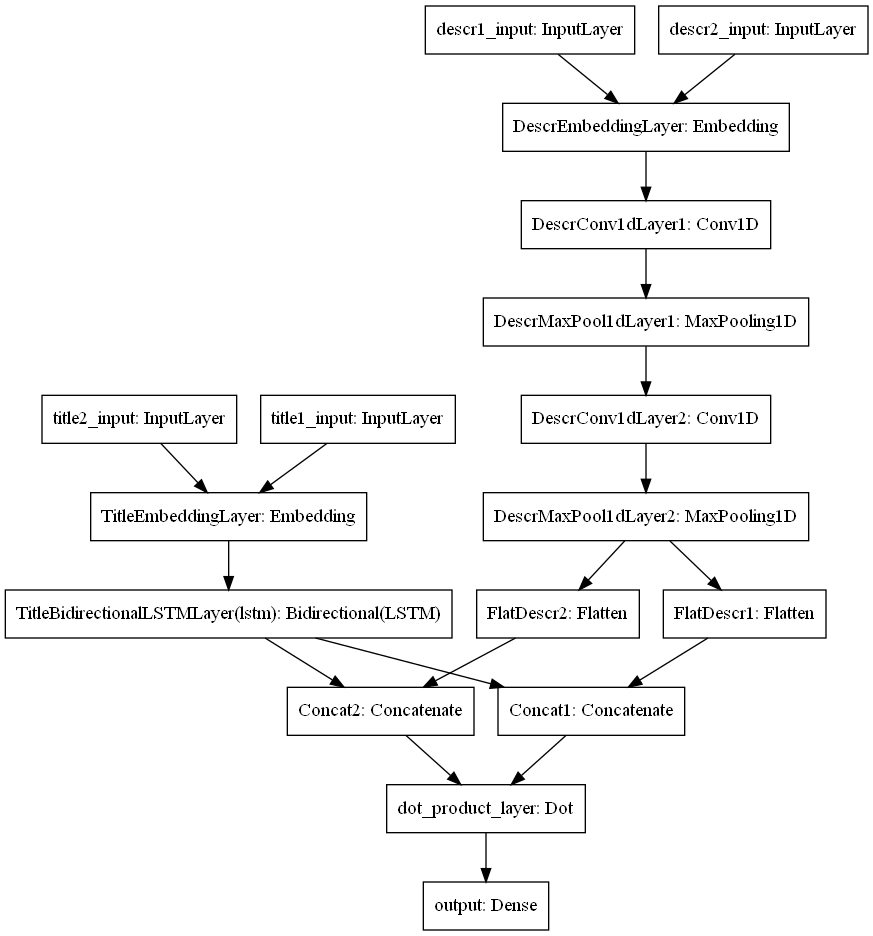

In [30]:
def create_siamese_component(num: int):
  class SiameseComponent:
    def __init__(self, title: layers.Input, description: layers.Input, output: layers.Concatenate):
      self.title = title
      self.description = description
      self.output = output

  title_input = layers.Input(shape=(None,), dtype='int32', name=f'title{num}_input')
  title_embedding_layer = TitleEmbeddingLayer(title_input)
  title_lstm_layer = TitleLSTMLayer(title_embedding_layer)

  descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
  descr_embedding_layer = DescrEmbeddingLayer(descr_input)
  descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
  descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
  descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
  descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
  # descr_conv1d3 = DescrConv1dLayer3(descr_max_pool1d2)
  # descr_max_pool1d3 = DescrMaxPool1dLayer3(descr_conv1d3)
  descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)

  concat = layers.Concatenate(axis=1, name=f'Concat{num}')([title_lstm_layer, descr_flat_Layer])
  return SiameseComponent(title_input, descr_input, concat)


component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(
  axes=1,
  name='dot_product_layer'
)([component1.output, component2.output])
output = layers.Dense(
  1, activation='sigmoid', name='output',
)(dot_product_layer)
siamese_model = models.Model(
  inputs=[component1.title, component2.title, component1.description, component2.description],
  outputs=output,
  name='siamese_model'
)

kutils.plot_model(siamese_model)

### Train

In [ ]:
BATCH_SIZE = 2048

siamese_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['acc'],
)
callback = callbacks.ModelCheckpoint(
    filepath=f'../../models/siamese'
             '.epoch-{epoch:02d}-loss-{val_loss:.3f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min',
)
history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=20,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1,
  callbacks=[callback],
)

Epoch 1/20
  4/105 [>.............................] - ETA: 6:07 - loss: 0.6386 - acc: 0.5919

In [ ]:
ax = pd.DataFrame(history.history).plot()